### Entrainement SIMCLR sur 8 * 26 + Fine Tuning sur 4 *26 et compraison avec Resnet

#### Gel du modele et entrainement de la tete de classification uniquement dans les deux cas 

In [7]:
import torch 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.models import resnet50
import numpy as np
import torch.nn.functional as F



In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((255, 255)),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\Dataset\\Indonesian_dataset\\indonesian_train_2',transform=transform)
val_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_test_dataset',transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle=False)

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\abassoma\AppData\Local\Temp\ipykernel_17984\3707777726.py:4: SyntaxWarning: invalid escape sequence '\D'
  train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\Dataset\\Indonesian_dataset\\indonesian_train_2',transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98931086..0.7286794].


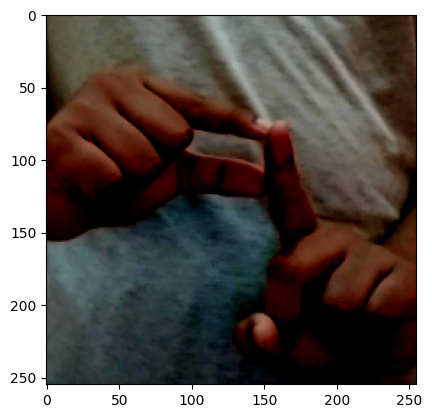

In [9]:
def showImage(img):
    img = np.array(img)
    img = img.transpose(1,2,0)
    plt.imshow(img)

x = next(iter((train_loader)))[0][2]
showImage(x)

t5= transforms.RandomAffine(
    degrees=0,  
    translate=(0.5, 0))
x4= t5(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98931086..0.7286794].


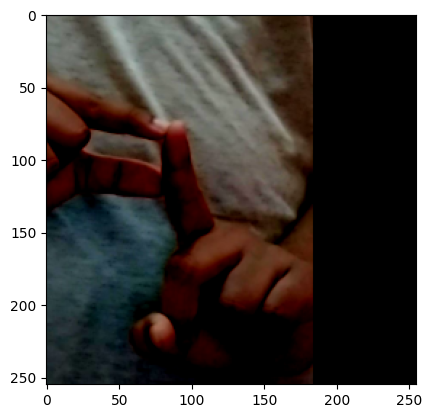

In [10]:
showImage(x4)

In [12]:
model2 = resnet50(pretrained=True).to('cuda')
num_feature = model2.fc.in_features
model2.fc = nn.Linear(num_feature,26)

for param in model2.parameters():
    param.requires_grad = False

for param in model2.fc.parameters():
    param.requires_grad = True

AssertionError: Torch not compiled with CUDA enabled

In [18]:
nvcc --version


NameError: name 'nvcc' is not defined

In [6]:
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
import torch.nn.functional as F

class Module(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = model2
        # Définir la loss function
        self.criterion = nn.CrossEntropyLoss()
        
        num_classes = 26
        # Définir les métriques
        self.train_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        
        self.val_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        self.val_recall = TM.Recall(task='multiclass', num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.train_acc(preds, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.val_acc(preds, targets)
        self.val_recall(preds, targets)  
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_acc', self.val_acc, on_step=True, on_epoch=True)
        self.log('val_recall', self.val_recall, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        # Optimiser uniquement les paramètres du classifieur (la dernière couche)
        return optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)


In [7]:
my_module = Module()
trainer = L.Trainer(max_epochs=45)
trainer.fit(
    my_module,
    train_loader,
    test_loader
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | model      | ResNet             | 23.6 M | train
1 | criterion  | CrossEntropyLoss   | 0      | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | train_top3 | MulticlassAccuracy | 0      | train
4 | val_acc    | MulticlassAccuracy | 0      | train
5 | val_top3   | MulticlassAccuracy | 0      | train
6 | val_recall | MulticlassRecall   | 0      | train
----------------------------------------------------------
53.3 K    Trainable params
23.5 M    Non-trainable params
23.6 M    Total params
94.245    Total estimated model params size (MB)
157       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\abassoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\abassoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\abassoma\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 44: 100%|██████████| 3/3 [00:15<00:00,  0.19it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=45` reached.


Epoch 44: 100%|██████████| 3/3 [00:16<00:00,  0.18it/s, v_num=1]


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((255, 255))  
])

train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_1',transform=transform)
val_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_2',transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle=True)

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import random

# Liste des transformations d'images
transformation_list = [
    
      transforms.RandomAffine(degrees=0, translate=(0.1, 0)),  # Translation horizontale de 10%
      transforms.RandomAffine(degrees=0, translate=(0.2, 0)),  # Translation horizontale de 20%
      transforms.RandomAffine(degrees=0, translate=(0.3, 0)),  # Translation horizontale de 30%
      transforms.RandomAffine(degrees=0, translate=(0.4, 0)),  # Translation horizontale de 40%
      transforms.RandomAffine(degrees=0, translate=(0.5, 0)),  # Translation horizontale de 50%
      transforms.RandomAffine(degrees=0, translate=(0.6, 0)),  # Translation horizontale de 60%
      transforms.RandomAffine(degrees=0, translate=(0.7, 0)),  # Translation horizontale de 70%
      transforms.RandomAffine(degrees=0, translate=(0.8, 0)),  # Translation horizontale de 80%
      transforms.RandomAffine(degrees=0, translate=(0.9, 0))   # Translation horizontale de 90%

    
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.2)),
    # transforms.ColorJitter(brightness=0.5),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.7)),
    # transforms.RandomGrayscale(p=0.2), 
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  
    # transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),  
    # transforms.RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3))  
]

# Fonction pour choisir une transformation aléatoire
def random_choose(transformation_list):
    p = random.randint(0, len(transformation_list) - 1)
    return transformation_list[p]

# Générer deux batchs d'images transformées
def generate_batch(batch_image):
    first_batch = []
    second_batch = []
    
    for im in batch_image:
        transform_batch_1 = random_choose(transformation_list)
        transform_batch_2 = random_choose(transformation_list)
        x = transform_batch_1(im)
        y = transform_batch_2(im)
        first_batch.append(x)
        second_batch.append(y)
    
    # Convertir les listes en tenseurs en empilant directement
    first_batch_tensor = torch.stack(first_batch)
    second_batch_tensor = torch.stack(second_batch)
    
    return first_batch_tensor, second_batch_tensor


In [9]:
from lightly.loss import NTXentLoss

In [10]:
model = resnet50(pretrained=True)

class HeadProjection(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1000, 200)
        self.fc2 = nn.Linear(200,29)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

Projection = HeadProjection()

c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\abassoma\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
import matplotlib.pyplot as plt
from pytorch_metric_learning import losses
criterion = NTXentLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=0.001)

def training(train_loader, test_loader, num_epochs):
    epoch_losses = [] 
    test_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print('Début de l\'époque', epoch + 1)
        
        for step, (data, label) in enumerate(train_loader):
            data, label = data, label
            optimizer.zero_grad()
            
            batch_1, batch_2 = generate_batch(data)
            batch_1, batch_2 = batch_1, batch_2
            
            output_1 = model(batch_1)
            output_2 = model(batch_2)
            
            outputs_1 = Projection(output_1)
            outputs_2 = Projection(output_2)
            
            loss = criterion(outputs_1, outputs_2)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)

        
    # Plot des erreurs d'entraînement et de test
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss per Epoch')
    plt.grid(True)
    plt.legend()
    plt.savefig('Training_and_Test_loss_simclr.png')
    plt.show()

training(train_loader, test_loader, 70)


Début de l'époque 1
Début de l'époque 2


KeyboardInterrupt: 

In [13]:
num_ftrs = model.fc.in_features 
model.fc = nn.Linear(num_ftrs,26)

# Geler toutes les couches du modèle SimCLR pré-entraîné
for param in model.parameters():
    param.requires_grad = False

# Débloquer uniquement la dernière couche fully connected (fc)
for param in model.fc.parameters():
    param.requires_grad = True


In [14]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224, 224)),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_train_2',transform=transform)
val_set = datasets.ImageFolder(root='C:\\Users\\abassoma\\Documents\\Dataset\\Indonesian_dataset\\indonesian_test_dataset',transform=transform)
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(val_set,batch_size,shuffle=False)

In [15]:
import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics as TM
import torch.nn.functional as F

class Module(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = model
        # Définir la loss function
        self.criterion = nn.CrossEntropyLoss()
        
        num_classes = 26
        # Définir les métriques
        self.train_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.train_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        
        self.val_acc = TM.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_top3 = TM.Accuracy(task='multiclass', num_classes=num_classes, top_k=3)
        self.val_recall = TM.Recall(task='multiclass', num_classes=num_classes)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.train_acc(preds, targets)
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        logits = self.model(images)
        loss = self.criterion(logits, targets)
        preds = torch.argmax(logits, dim=-1)
        self.val_acc(preds, targets)
        self.val_recall(preds, targets)  
        self.log('val_loss', loss, on_step=True, on_epoch=True)
        self.log('val_acc', self.val_acc, on_step=True, on_epoch=True)
        self.log('val_recall', self.val_recall, on_step=True, on_epoch=True)

    def configure_optimizers(self):

        return optim.SGD(self.model.parameters(), lr=0.001, momentum=0.9)


In [16]:
my_module = Module()
trainer = L.Trainer(max_epochs=60)
trainer.fit(
    my_module,
    train_loader,
    test_loader
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | model      | ResNet             | 23.6 M | train
1 | criterion  | CrossEntropyLoss   | 0      | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | train_top3 | MulticlassAccuracy | 0      | train
4 | val_acc    | MulticlassAccuracy | 0      | train
5 | val_top3   | MulticlassAccuracy | 0      | train
6 | val_recall | MulticlassRecall   | 0      | train
----------------------------------------------------------
53.3 K    Trainable params
23.5 M    Non-trainable params
23.6 M    Total params
94.245    Total estimated model params size (MB)
157       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\abassoma\AppData\Local\miniconda3\envs\dl\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\abassoma\AppData\Local\miniconda3\envs\dl\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\abassoma\AppData\Local\miniconda3\envs\dl\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=60` reached.


In [17]:
%load_ext tensorboard
# %tensorboard --logdir lightning_logs/  
%tensorboard --logdir lightning_logs/  --port 9096

Reusing TensorBoard on port 9096 (pid 36728), started 2:21:19 ago. (Use '!kill 36728' to kill it.)